<a href="https://colab.research.google.com/github/anosharahim/deep-learning/blob/master/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages and Libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
## for preprocessing
import pandas as pd
import os
import numpy as np
import random 

## For plotting
import seaborn as sns
import imageio
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
from IPython.display import Image
%matplotlib inline


## For machine learning
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Load and Preprocess Image Data

The FER-2013 dataset consists of close-up face photos at varying angles. The photos are grayscale, whereas ResNet50 requires a 3-channel RGB input. In order to emulate this, we can layer the grayscale with two additional channels that are duplicates of the original grayscale channel. Since the image will be the same overall three channels, the performance of the neural network should be the same as it was on RGB images. 

Other preprocessing included resizing the image to fit the ResNet50 requirements, shuffling and splitting the dataset into the train, test, and validation data, as well as finding ways to deal with class imbalance. In FER-2013, the highest number of samples belong to the class “Happiness” with 7000 images, and the smallest class is the “Disgust” class with only a couple of hundred training samples. Most other classes are between 5000 and 3000 training samples. Class imbalance is an important issue to address because it can render the accuracy metric an unreliable measure of classification performance. This is because the model can learn to predict the majority class for all examples and still end up with a high accuracy, which will deprioritize the model’s tendency to accurately predict minority classes. In order to deal with this issue, I chose the method of data resampling to balance out the class distribution. This includes undersampling the majority class of “Happiness”, and oversampling the minority class of “Disgust”.

In [ ]:
#get file paths for training and test images
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

#initialize lists to save data
train_data = []
train_label = []
test_data = []
test_label = []

#y label encoding in a dictionary
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}

def unison_shuffled_copies(a, b):
    '''Shuffles two arrays in sync using permutations.'''
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_image_arrays(folder_path, label_dict):
  '''Converts png images into numpy arrays with their labels and stores them in a shuffled array.

  Input:
  folder_path - Path to folder where images for each emotion are stored in a different folder
  label_dict - Dictionary of labels and their encodings   

  Output:
  data -  Array of image arrays
  label - Array of image labels 
  '''

  data = []
  label = []

  for category in os.listdir(folder_path): 
    category_name = label_dict[category]
    category_path = folder_path + category + '/'
    freq[category] = 0

    for image in os.listdir(category_path):
      image_file = category_path + image 
      image_array = imageio.imread(image_file) #get image array from file 
      #image_array.resize((32, 32))
      image_array = np.array(image_array) #convert to numpy array 
      #add image array and it's label to respective folders 
      data.append(image_array)
      label.append(category_name)

  data = np.array(data)
  label = np.array(label)
  data, label = unison_shuffled_copies(data, label)
  return data, label

#get test and training data in numpy array format from png files
train_data, train_label = get_image_arrays(train_path, emotion_dictionary)
test_data, test_label = get_image_arrays(test_path, emotion_dictionary)

#save test and training set for future use 
np.savez('/content/drive/MyDrive/Capstone/datasets/train.npz',train_data, train_label)
np.savez('/content/drive/MyDrive/Capstone/datasets/test.npz',test_data, test_label)


In [ ]:
#load data from gdrive
train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

#check sizes
print('Train Size: ', x_train.shape, y_train.shape)
print('Test Size: ',x_test.shape, y_test.shape)

Train Size:  (28709, 48, 48) (28709,)
Test Size:  (7178, 48, 48) (7178,)


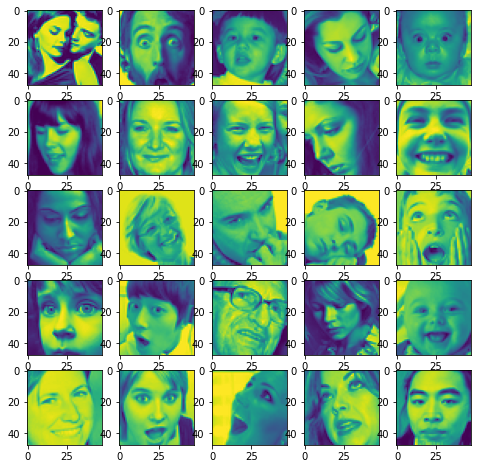

In [ ]:
#visualize random samples
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[random.randint(0,len(x_train))])

Text(0.5, 1.0, 'Emotion Class Distribution in Training Data')

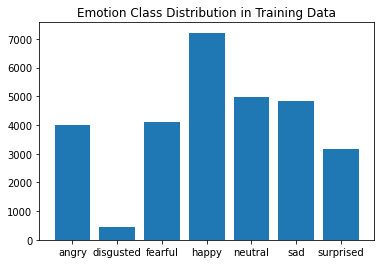

In [ ]:
### CLASS IMBALANCE 

#visualize class distribution
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}
values, counts = np.unique(y_train, return_counts=True)

class_dist = {} #true class distribution
for i in range(len(values)):
  class_dist[i] = counts[i]

plt.bar(emotion_dictionary.keys(),class_dist.values())
plt.title("Emotion Class Distribution in Training Data")

<BarContainer object of 7 artists>

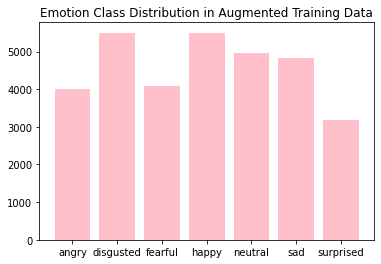

In [ ]:
#randomly undersample majority class 
class_undersample =  {0: 3995, 1: 436, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
x_train_reshape = x_train.reshape(len(x_train),48*48)
undersample = RandomUnderSampler(sampling_strategy=class_undersample)
x_train_under, y_train_under = undersample.fit_resample(x_train_reshape,y_train)

#oversample minority class  using k-nearest data augmentation
class_oversample =  {0: 3995, 1: 3500, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train, y_train = sm.fit_resample(x_train_under,y_train_under)

#visualize resampled class distribution 
values, counts_ = np.unique(y_train, return_counts=True)
plt.title("Emotion Class Distribution in Augmented Training Data")
plt.bar(emotion_dictionary.keys(),counts_, color = 'pink')

In [ ]:
#add 2 more channels to grayscale image to imitate rgb
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

#split test set into validation and test set 
x_val, x_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.3)

#resize to make sure input is the correct shape
x_train = np.resize(x_train, (len(x_train), 48,48,3))
x_val = np.resize(x_val, (len(x_val), 48,48,3))
x_test = np.resize(x_test, (len(x_test), 48,48,3))

print('Train -- ', x_train.shape, y_train.shape)
print('Val -- ', x_val.shape, y_val.shape)
print('Test -- ', x_test.shape, y_test.shape)


Train --  (32058, 48, 48, 3) (32058,)
Val --  (5024, 48, 48, 3) (5024,)
Test --  (2154, 48, 48, 3) (2154,)


In [ ]:
#Load Pretrained ResNet50 Model 
input_tensor = K.Input(shape=(48,48,3))
res50_model = K.applications.ResNet50(include_top=False, weights="imagenet",input_tensor=input_tensor)

#Freezing Layers 
n_freeze = 143
for layer in res50_model.layers[:n_freeze]:
  layer.trainable =False

#verify that the desired layers are frozen 
for i, layer in enumerate(res50_model.layers):
  if i == 10:
    print("...")
  if i < 10 or i > (n_freeze - 3):  
    print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
...
141 conv4_block6_add - False
142 conv4_block6_out - False
143 conv5_block1_1_conv - True
144 conv5_block1_1_bn - True
145 conv5_block1_1_relu - True
146 conv5_block1_2_conv - True
147 conv5_block1_2_bn - True
148 conv5_block1_2_relu - True
149 conv5_block1_0_conv - True
150 conv5_block1_3_conv - True
151 conv5_block1_0_bn - True
152 conv5_block1_3_bn - True
153 conv5_block1_add - True
154 conv5_block1_out - True
155 conv5_block2_1_conv - True
156 conv5_block2_1_bn - True
157 conv5_block2_1_relu - True
158 conv5_block2_2_conv - True
159 conv5_block2_2_bn - True
160 conv5_block2_2_relu - True
161 conv5_block2_3_conv - True
162 conv5_block2_3_bn - True
163 conv5_block2_add - True
164 conv5_block2_out - True
165 conv5_block3_1_conv - True
166 conv5_block3_1_bn -

In [ ]:
## Build the model
model=K.models.Sequential()
model.add(res50_model) #pre-trained model with frozen layers 
# stacking more layers 
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dense(7,activation='softmax'))


## Compile Model 

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

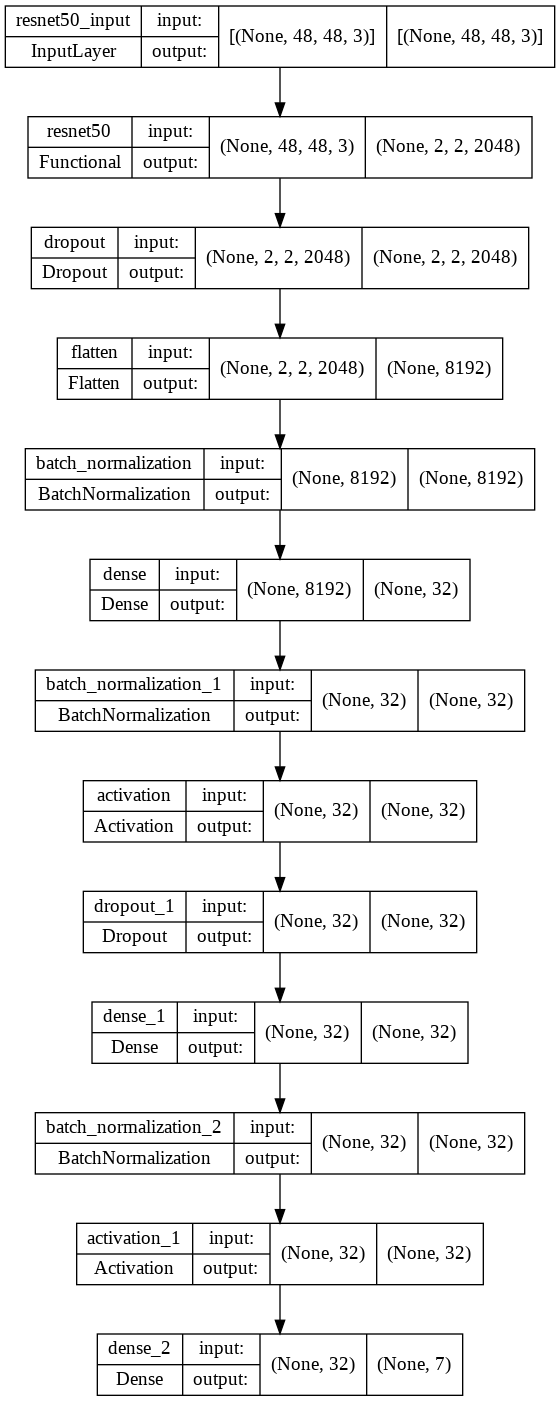

In [ ]:
plot_model(model, to_file='/content/drive/MyDrive/Capstone/datasetsmodel_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

#create path to checkpoint to save model weights
ckpt_path = os.path.join('/content/drive/MyDrive/Capstone/datasets', 'ckpt') 

#reduce learning rate when performance doesn't increase for 5 epochs
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.1, min_lr = 1e-10)
#stop early if performance doesn't increase substantially for 10 epochs
#es = EarlyStopping(min_delta=.001, verbose=1, patience=15)

#create model checkpoint to save weights
check_point = K.callbacks.ModelCheckpoint(filepath=  ckpt_path,
                                              monitor="val_accuracy",
                                              mode="max",
                                              save_best_only=True,)

#Train the model using min--batch gradient descent
history = model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=1,
                        validation_data=(x_val, y_val),
                        callbacks=[lrd, check_point])

model.save(ckpt_path)

Epoch 1/100
1002/1002 [==============================] - 118s 101ms/step - loss: 1.5344 - accuracy: 0.4129 - val_loss: 1.4712 - val_accuracy: 0.4429 - lr: 0.0010
Epoch 2/100
1002/1002 [==============================] - 98s 98ms/step - loss: 1.3403 - accuracy: 0.4955 - val_loss: 1.4203 - val_accuracy: 0.4652 - lr: 0.0010
Epoch 3/100
1002/1002 [==============================] - 98s 98ms/step - loss: 1.2414 - accuracy: 0.5369 - val_loss: 1.3394 - val_accuracy: 0.4992 - lr: 0.0010
Epoch 4/100
1002/1002 [==============================] - 97s 97ms/step - loss: 1.1698 - accuracy: 0.5639 - val_loss: 1.3179 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 5/100
1002/1002 [==============================] - 102s 102ms/step - loss: 1.1014 - accuracy: 0.5888 - val_loss: 1.2979 - val_accuracy: 0.5157 - lr: 0.0010
Epoch 6/100
1002/1002 [==============================] - 66s 65ms/step - loss: 1.0306 - accuracy: 0.6228 - val_loss: 1.3890 - val_accuracy: 0.4887 - lr: 0.0010
Epoch 7/100
1002/1002 [=============

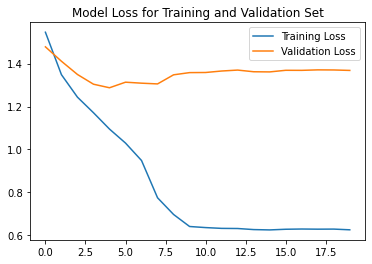

In [ ]:
hist = history.history
train_acc = hist['accuracy']
train_loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

plt.title("Model Loss for Training and Validation Set")
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

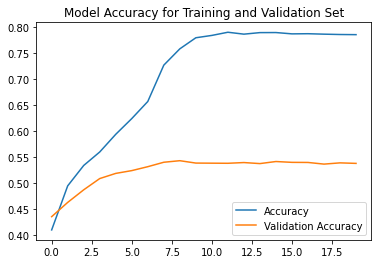

In [ ]:
plt.title("Model Accuracy for Training and Validation Set")
plt.plot(train_acc, label = 'Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend()

# Testing & Interpreting the Model 




In [ ]:
# Re-evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

68/68 [==============================] - 2s 36ms/step - loss: 1.3906 - accuracy: 0.5320
Restored model, accuracy: 53.20%
